## 2. Load Data and Train a model then save the model's weight

**Used Hyperparameter**<br>
Without Data Augmentation<br>


-----------------------<br>
Level: 2,3 images <br>
Number of train,val,test: 9, 3, 3 <br>
train's stride : 200 <br>
test's stride: 299 <br>
tissue percent min: 50 <br>


In [ ]:
import numpy as np
import os
from PIL import Image
import pathlib
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from itertools import chain
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from matplotlib.patches import Rectangle
import re
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [ ]:
import os

# Initialization
lowest_level = 2
highest_level = 3
train_val_stride = 200
test_stride = 299
tissue_p_min = 50

dir = '/content/drive/MyDrive/Applied_Deep_Learning_Project/'
current_dir = 'Lev_23_split_933_stride_200_pmin_50'
saving_dir = os.path.join(dir,current_dir)
saving_dir

'/content/drive/MyDrive/Applied_Deep_Learning_Project/Lev_23_split_933_stride_200_pmin_50'

In [ ]:
# Mount drive
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)
print()

# Check TensorFlow version
import tensorflow as tf 
print("TF version: ", tf.__version__)
print()

# Check which GPU with available RAM
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

Mounted at /content/drive

TF version:  2.4.0

Found GPU at: /device:GPU:0
name, driver_version, memory.total [MiB]
Tesla P100-PCIE-16GB, 418.67, 16280 MiB


In [ ]:
zoom1_train = np.load(os.path.join(saving_dir,'zoom1_train.npy'))
zoom2_train = np.load(os.path.join(saving_dir,'zoom2_train.npy'))
label_train = np.load(os.path.join(saving_dir,'label_train.npy'))

zoom1_valid = np.load(os.path.join(saving_dir,'zoom1_valid.npy'))
zoom2_valid = np.load(os.path.join(saving_dir,'zoom2_valid.npy'))
label_valid = np.load(os.path.join(saving_dir,'label_valid.npy'))

X_train = [zoom1_train, zoom2_train]
X_valid = [zoom1_valid, zoom2_valid]
BATCH_SIZE = 32

In [ ]:
def create_inceptionv3(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  base_model.trainable = False
  return base_model


def create_inceptionv3_fine_tune(weights='imagenet',include_top = False, input_shape = (299,299,3)):
  base_model = tf.keras.applications.InceptionV3(weights=weights,include_top = include_top, input_shape = input_shape)
  
  base_model.trainable = True
  # Let's take a look to see how many layers are in the base model
  print("Number of layers in the base InceptionV3 model: ", len(base_model.layers))
  # Fine-tune from this layer onwards
  fine_tune_at = 100
  print("Start fine tuning at layer: ", fine_tune_at)

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

  return base_model


def create_global_avg_layer():
  return tf.keras.layers.GlobalAveragePooling2D()


def create_dense_layer():
  return tf.keras.layers.Dense(1024, activation='relu')

In [ ]:
# Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two(fine_tune):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
    
  model_concat = concatenate([model_1(input1) ,model_2(input2)])
  model = Dense(1024, activation='relu')(model_concat)
  model = Dense(1, activation='sigmoid')(model)
  model_final = Model(inputs=[input1,input2],outputs=model)

  return model_final

In [ ]:
# A plotting function you can reuse
def plot(history):
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  # added new version for better layout in visualization (for fun)
  fig, ax = plt.subplots(1,2, figsize = (14,5))
  ax[0].set_title('Training and validation accuracy')
  ax[0].plot(epochs, acc, color='blue', label='Train')
  ax[0].plot(epochs, val_acc, color='orange', label='Val')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()

  ax[1].set_title('Training and validation loss')
  ax[1].plot(epochs, loss, color='blue', label='Train')
  ax[1].plot(epochs, val_loss, color='orange', label='Val')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()

### Version a: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         23900960    input_3[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 1024)         23900960    input_4[0][0]                    
______________________________________________________________________________________________

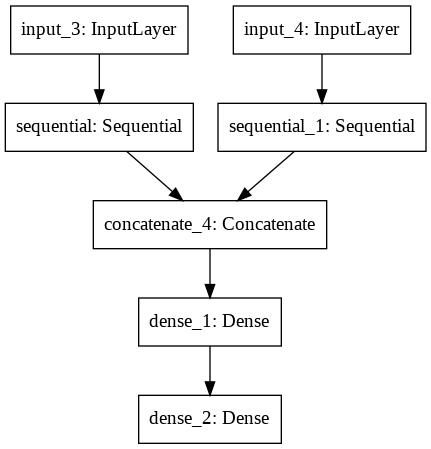

In [ ]:
mdl_9_3_wo_ft_wo_da = create_model_keras_inputs_two(fine_tune = False)
mdl_9_3_wo_ft_wo_da.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da))

Epoch 1/10
173/173 [==============================] - 38s 171ms/step - loss: 6.3057 - accuracy: 0.7765 - val_loss: 0.7251 - val_accuracy: 0.7155
Epoch 2/10
173/173 [==============================] - 26s 152ms/step - loss: 0.2589 - accuracy: 0.9066 - val_loss: 0.5986 - val_accuracy: 0.7138
Epoch 3/10
173/173 [==============================] - 26s 152ms/step - loss: 0.2301 - accuracy: 0.9119 - val_loss: 0.9442 - val_accuracy: 0.6293
Epoch 4/10
173/173 [==============================] - 26s 152ms/step - loss: 0.2236 - accuracy: 0.9122 - val_loss: 1.1252 - val_accuracy: 0.6517
Epoch 5/10
173/173 [==============================] - 26s 152ms/step - loss: 0.1964 - accuracy: 0.9217 - val_loss: 1.3044 - val_accuracy: 0.5828
Epoch 6/10
173/173 [==============================] - 26s 152ms/step - loss: 0.1814 - accuracy: 0.9236 - val_loss: 1.7857 - val_accuracy: 0.5724
Epoch 7/10
173/173 [==============================] - 26s 152ms/step - loss: 0.1582 - accuracy: 0.9377 - val_loss: 0.9017 - val_ac

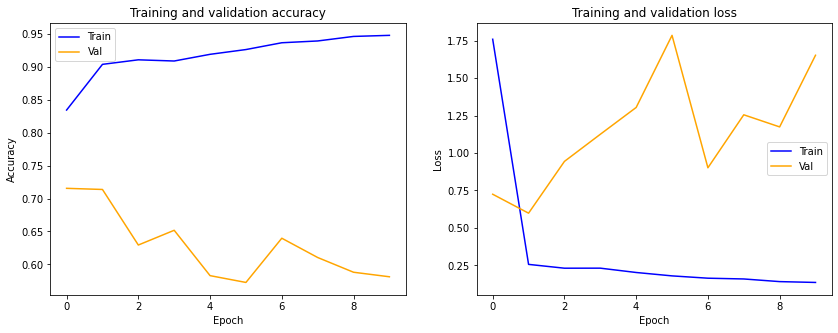

In [ ]:
mdl_9_3_wo_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE,
                             validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da.h5/"))

del mdl_9_3_wo_ft_wo_da

### Version b: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **without** data augmentation

In [ ]:
mdl_9_3_w_ft_wo_da = create_model_keras_inputs_two(fine_tune = True)
mdl_9_3_w_ft_wo_da.summary()
# display(plot_model(mdl_9_3_w_ft_wo_da))

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1024)         23900960    input_7[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Seque

Epoch 1/10
173/173 [==============================] - 67s 324ms/step - loss: 0.4555 - accuracy: 0.8272 - val_loss: 6.3531 - val_accuracy: 0.5000
Epoch 2/10
173/173 [==============================] - 54s 310ms/step - loss: 0.1886 - accuracy: 0.9298 - val_loss: 2.1149 - val_accuracy: 0.5000
Epoch 3/10
173/173 [==============================] - 54s 310ms/step - loss: 0.1336 - accuracy: 0.9545 - val_loss: 1.9767 - val_accuracy: 0.5000
Epoch 4/10
173/173 [==============================] - 54s 310ms/step - loss: 0.1309 - accuracy: 0.9538 - val_loss: 1.6593 - val_accuracy: 0.4586
Epoch 5/10
173/173 [==============================] - 54s 310ms/step - loss: 0.1086 - accuracy: 0.9640 - val_loss: 1.0558 - val_accuracy: 0.6207
Epoch 6/10
173/173 [==============================] - 54s 310ms/step - loss: 0.0933 - accuracy: 0.9669 - val_loss: 2.4283 - val_accuracy: 0.6207
Epoch 7/10
173/173 [==============================] - 54s 312ms/step - loss: 0.0980 - accuracy: 0.9610 - val_loss: 3.1423 - val_ac

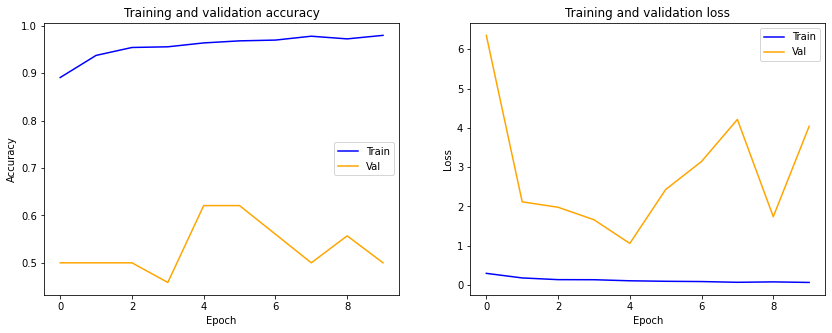

In [ ]:
mdl_9_3_w_ft_wo_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_w_ft_wo_da.fit(X_train,label_train, batch_size=BATCH_SIZE, 
                             validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_w_ft_wo_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_wo_da.h5/"))

del mdl_9_3_w_ft_wo_da

### Version c: <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **with** data augmentation

In [ ]:
# Reference used to take multiple inputs for ImageData Geneartor
# https://stackoverflow.com/questions/49404993/keras-how-to-use-fit-generator-with-multiple-inputs

gen = ImageDataGenerator(
    rotation_range=90,
    shear_range=0.2)
    # horizontal_flip = True,
    # vertical_flip = True)

gen_valid = ImageDataGenerator()

def generator_two_img(X1, X2, y, batch_size):
    genX1 = gen.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

def generator_two_img_valid(X1, X2, y, batch_size):
    genX1 = gen_valid.flow(X1, y,  batch_size=batch_size, seed=1)
    genX2 = gen_valid.flow(X2, y, batch_size=batch_size, seed=1)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

X_train_ = generator_two_img(zoom1_train, zoom2_train, label_train, 32)
X_valid_ = generator_two_img_valid(zoom1_valid, zoom2_valid, label_valid, 32)
BATCH_SIZE = 32

In [ ]:
mdl_9_3_wo_ft_w_da = create_model_keras_inputs_two(fine_tune = False)
mdl_9_3_wo_ft_w_da.summary()
# display(plot_model(mdl_9_3_wo_ft_w_da))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1024)         23900960    input_11[0][0]                   
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1024)         23900960    input_12[0][0]                   
____________________________________________________________________________________________

Epoch 1/15
172/172 [==============================] - 186s 1s/step - loss: 6.6403 - accuracy: 0.7809 - val_loss: 0.7882 - val_accuracy: 0.6672
Epoch 2/15
172/172 [==============================] - 175s 1s/step - loss: 0.3225 - accuracy: 0.8721 - val_loss: 2.0756 - val_accuracy: 0.5741
Epoch 3/15
172/172 [==============================] - 175s 1s/step - loss: 0.2850 - accuracy: 0.8861 - val_loss: 1.3950 - val_accuracy: 0.5345
Epoch 4/15
172/172 [==============================] - 177s 1s/step - loss: 0.2586 - accuracy: 0.8974 - val_loss: 0.7791 - val_accuracy: 0.7000
Epoch 5/15
172/172 [==============================] - 175s 1s/step - loss: 0.2597 - accuracy: 0.8999 - val_loss: 1.3753 - val_accuracy: 0.5914
Epoch 6/15
172/172 [==============================] - 176s 1s/step - loss: 0.2698 - accuracy: 0.8928 - val_loss: 0.7154 - val_accuracy: 0.6879
Epoch 7/15
172/172 [==============================] - 175s 1s/step - loss: 0.2355 - accuracy: 0.9016 - val_loss: 0.9048 - val_accuracy: 0.6448

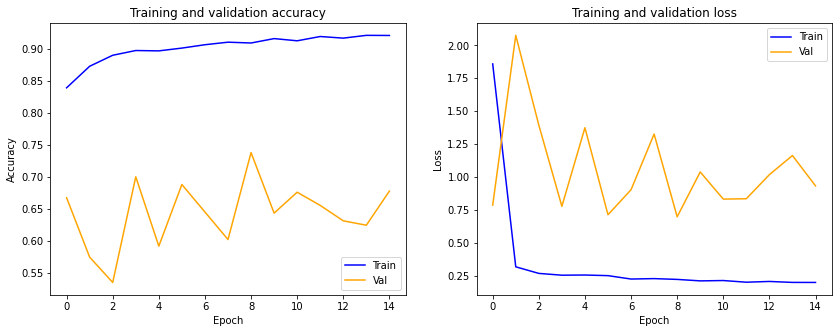

In [ ]:
mdl_9_3_wo_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
                            steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
                            validation_data =X_valid_, validation_steps = len(zoom1_valid)/BATCH_SIZE,
                            shuffle=False, epochs=15))

In [ ]:
#save_weights
mdl_9_3_wo_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_w_da.h5/"))

del mdl_9_3_wo_ft_w_da

### Version d: <br>
#### A model train with 9 train, 3 val [per image]
#### model **with** fine tuning and **with** data augmentation

In [ ]:
mdl_9_3_w_ft_w_da = create_model_keras_inputs_two(fine_tune = True)
mdl_9_3_w_ft_w_da.summary()
# display(plot_model(mdl_9_3_w_ft_w_da))

Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Number of layers in the base InceptionV3 model:  311
Start fine tuning at layer:  100
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1024)         23900960    input_15[0][0]                   
__________________________________________________________________________________________________
sequential_7 (Seque

Epoch 1/15
172/172 [==============================] - 189s 1s/step - loss: 0.5253 - accuracy: 0.7833 - val_loss: 2.4569 - val_accuracy: 0.4259
Epoch 2/15
172/172 [==============================] - 178s 1s/step - loss: 0.2366 - accuracy: 0.9195 - val_loss: 10.1804 - val_accuracy: 0.4966
Epoch 3/15
172/172 [==============================] - 178s 1s/step - loss: 0.1724 - accuracy: 0.9322 - val_loss: 3.3666 - val_accuracy: 0.4983
Epoch 4/15
172/172 [==============================] - 178s 1s/step - loss: 0.1551 - accuracy: 0.9448 - val_loss: 1.4231 - val_accuracy: 0.5500
Epoch 5/15
172/172 [==============================] - 177s 1s/step - loss: 0.1342 - accuracy: 0.9479 - val_loss: 3.9771 - val_accuracy: 0.4862
Epoch 6/15
172/172 [==============================] - 177s 1s/step - loss: 0.1675 - accuracy: 0.9496 - val_loss: 1.3661 - val_accuracy: 0.5603
Epoch 7/15
172/172 [==============================] - 178s 1s/step - loss: 0.1046 - accuracy: 0.9641 - val_loss: 1.9574 - val_accuracy: 0.546

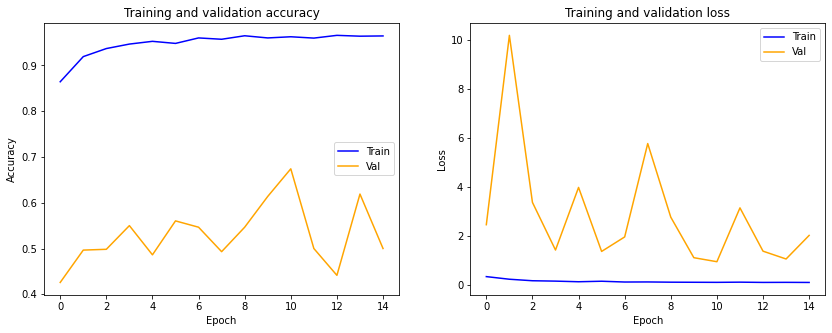

In [ ]:
mdl_9_3_w_ft_w_da.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_w_ft_w_da.fit(X_train_, batch_size=BATCH_SIZE, 
                steps_per_epoch = len(zoom1_train)/BATCH_SIZE,
                validation_data =X_valid_, validation_steps = len(zoom1_valid)/BATCH_SIZE, 
                shuffle=False, epochs=15))

In [ ]:
#save_weights
mdl_9_3_w_ft_w_da.save_weights(os.path.join(saving_dir,"mdl_9_3_w_ft_w_da.h5/"))

del mdl_9_3_w_ft_w_da

NameError: ignored

In [ ]:
# # Reference used to put multiple inputs
# # https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

# def create_model_keras_inputs_two_updated(fine_tune):

#   if fine_tune:
#     base_model_1 = create_inceptionv3_fine_tune()
#     base_model_2 = create_inceptionv3_fine_tune()
  
#   else: 
#     base_model_1 = create_inceptionv3()
#     base_model_2 = create_inceptionv3()

#   global_avg_layer = create_global_avg_layer()
#   dense_layer = create_dense_layer()
#   batch_norm_layer = create_batch_normalization()

#   model_1 = tf.keras.Sequential([
#     base_model_1,
#     global_avg_layer,
#     dense_layer,
#     #prediction_layer
#   ])

#   model_2 = tf.keras.Sequential([
#     base_model_2,
#     global_avg_layer,
#     dense_layer,
#     #prediction_layer
#   ])

#   input1 = Input(shape=(299,299,3))
#   input2 = Input(shape=(299,299,3))
    
#   model = concatenate([model_1(input1) ,model_2(input2)], axis =1)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(1024, activation='relu')(model)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(128, activation='relu')(model)
  
#   model = tf.keras.layers.BatchNormalization()(model)
#   model = tf.keras.layers.Dropout(0.3)(model)
#   model = Dense(1, activation='sigmoid')(model)

#   model_final = Model(inputs=[input1,input2],outputs=model)

#   return model_final

### Version 2.a: Batch Normalization <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normalization and extra dense layer

In [ ]:
def add_layers(model, add_BN, add_Dropout):
  if add_BN:
    if add_Dropout:
      print("Added BN and Dropout")
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = tf.keras.layers.Dropout(0.3)(model)
      model = Dense(1, activation='sigmoid')(model)
      return model
    
    else: # i.e. only add Batch Normalization
      print("Added only BN")
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1024, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(128, activation='relu')(model)
      model = tf.keras.layers.BatchNormalization()(model)
      model = Dense(1, activation='sigmoid')(model)
      return model

    
  else: # i.e. only apply Dropout
    print("Added only Dropout")
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1024, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(128, activation='relu')(model)
    model = tf.keras.layers.Dropout(0.3)(model)
    model = Dense(1, activation='sigmoid')(model)
    return model

In [ ]:
# Reference used to put multiple inputs
# https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

def create_model_keras_inputs_two_updated(fine_tune, add_BN, add_Dropout):

  if fine_tune:
    base_model_1 = create_inceptionv3_fine_tune()
    base_model_2 = create_inceptionv3_fine_tune()
  
  else: 
    base_model_1 = create_inceptionv3()
    base_model_2 = create_inceptionv3()

  global_avg_layer = create_global_avg_layer()
  dense_layer = create_dense_layer()

  model_1 = tf.keras.Sequential([
    base_model_1,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  model_2 = tf.keras.Sequential([
    base_model_2,
    global_avg_layer,
    dense_layer,
    #prediction_layer
  ])

  input1 = Input(shape=(299,299,3))
  input2 = Input(shape=(299,299,3))
    
  model = concatenate([model_1(input1) ,model_2(input2)], axis =1)
  model = add_layers(model = model, add_BN = add_BN, add_Dropout = add_Dropout)
  model_final = Model(inputs=[input1,input2],outputs=model)

  return model_final

Added only BN
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 1024)         23900960    input_9[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 1024)         23900960    input_10[0][0]                   
______________________________________________________________________________

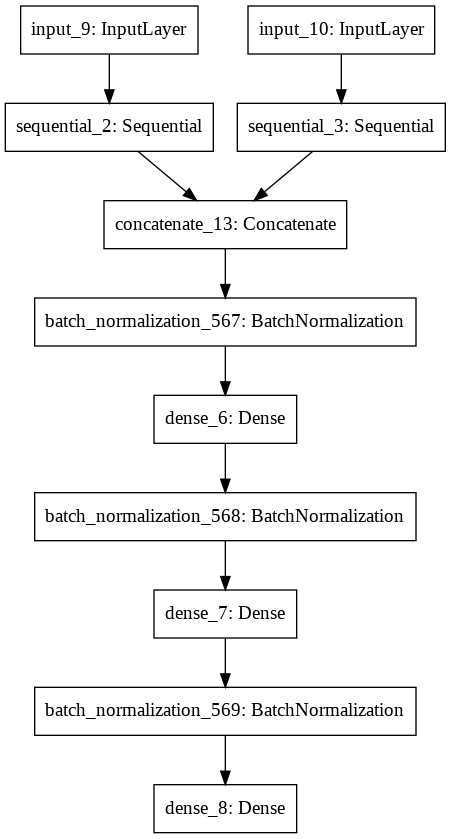

In [ ]:
mdl_9_3_wo_ft_wo_da_BN = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = False)
mdl_9_3_wo_ft_wo_da_BN.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_BN))

Epoch 1/10
173/173 [==============================] - 36s 167ms/step - loss: 0.3554 - accuracy: 0.8672 - val_loss: 1.8311 - val_accuracy: 0.5759
Epoch 2/10
173/173 [==============================] - 27s 155ms/step - loss: 0.2129 - accuracy: 0.9145 - val_loss: 1.0134 - val_accuracy: 0.5466
Epoch 3/10
173/173 [==============================] - 27s 155ms/step - loss: 0.2008 - accuracy: 0.9239 - val_loss: 2.0362 - val_accuracy: 0.5241
Epoch 4/10
173/173 [==============================] - 27s 155ms/step - loss: 0.1826 - accuracy: 0.9305 - val_loss: 0.9914 - val_accuracy: 0.6379
Epoch 5/10
173/173 [==============================] - 27s 155ms/step - loss: 0.1779 - accuracy: 0.9301 - val_loss: 1.7887 - val_accuracy: 0.5724
Epoch 6/10
173/173 [==============================] - 27s 155ms/step - loss: 0.1603 - accuracy: 0.9422 - val_loss: 1.0911 - val_accuracy: 0.6397
Epoch 7/10
173/173 [==============================] - 27s 155ms/step - loss: 0.1660 - accuracy: 0.9408 - val_loss: 0.9552 - val_ac

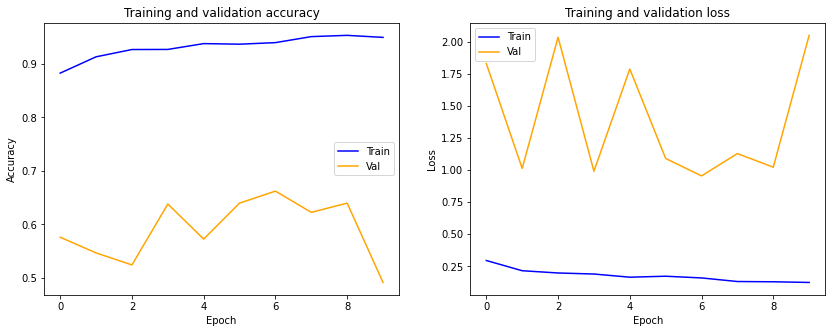

In [ ]:
mdl_9_3_wo_ft_wo_da_BN.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])

plot(mdl_9_3_wo_ft_wo_da_BN.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da_BN.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_BN.h5/"))

del mdl_9_3_wo_ft_wo_da_BN

### Version 2.b: Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Dropout and extra dense layer

Added only Dropout
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 1024)         23900960    input_13[0][0]                   
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1024)         23900960    input_14[0][0]                   
_________________________________________________________________________

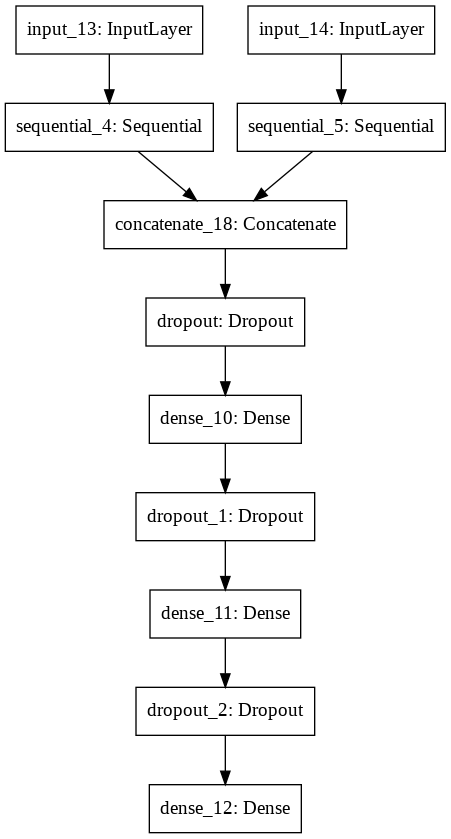

In [ ]:
mdl_9_3_wo_ft_wo_da_Dropout = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = False, add_Dropout = True)
mdl_9_3_wo_ft_wo_da_Dropout.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_Dropout))

Epoch 1/10
173/173 [==============================] - 36s 167ms/step - loss: 3.2107 - accuracy: 0.7137 - val_loss: 0.6995 - val_accuracy: 0.5966
Epoch 2/10
173/173 [==============================] - 27s 154ms/step - loss: 0.3835 - accuracy: 0.8427 - val_loss: 0.6935 - val_accuracy: 0.6431
Epoch 3/10
173/173 [==============================] - 27s 154ms/step - loss: 0.3376 - accuracy: 0.8709 - val_loss: 0.8224 - val_accuracy: 0.6276
Epoch 4/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2980 - accuracy: 0.8792 - val_loss: 0.8805 - val_accuracy: 0.6052
Epoch 5/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2632 - accuracy: 0.8929 - val_loss: 1.0910 - val_accuracy: 0.6345
Epoch 6/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2669 - accuracy: 0.9031 - val_loss: 0.8540 - val_accuracy: 0.6914
Epoch 7/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2543 - accuracy: 0.9033 - val_loss: 1.2008 - val_ac

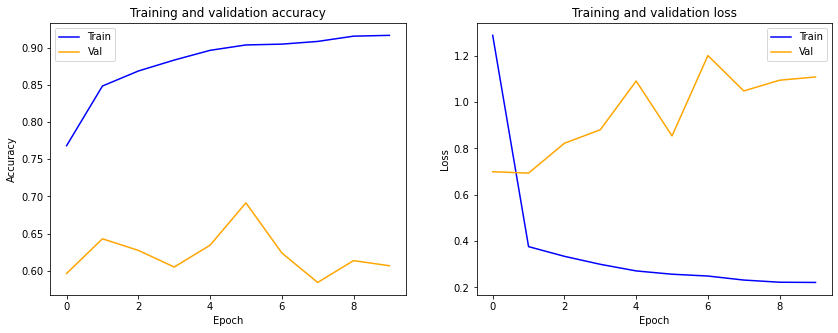

In [ ]:
mdl_9_3_wo_ft_wo_da_Dropout.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])


plot(mdl_9_3_wo_ft_wo_da_Dropout.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da_Dropout.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_Dropout.h5/"))

del mdl_9_3_wo_ft_wo_da_Dropout

### Version 2.c: Batch Norm + Dropout <br>
#### A model train with 9 train, 3 val [per image]
#### model **without** fine tuning and **without** data augmentation 
#### **Also** added Batch Normailzation, Dropout, and extra dense layer

Added BN and Dropout
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 1024)         23900960    input_17[0][0]                   
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 1024)         23900960    input_18[0][0]                   
_______________________________________________________________________

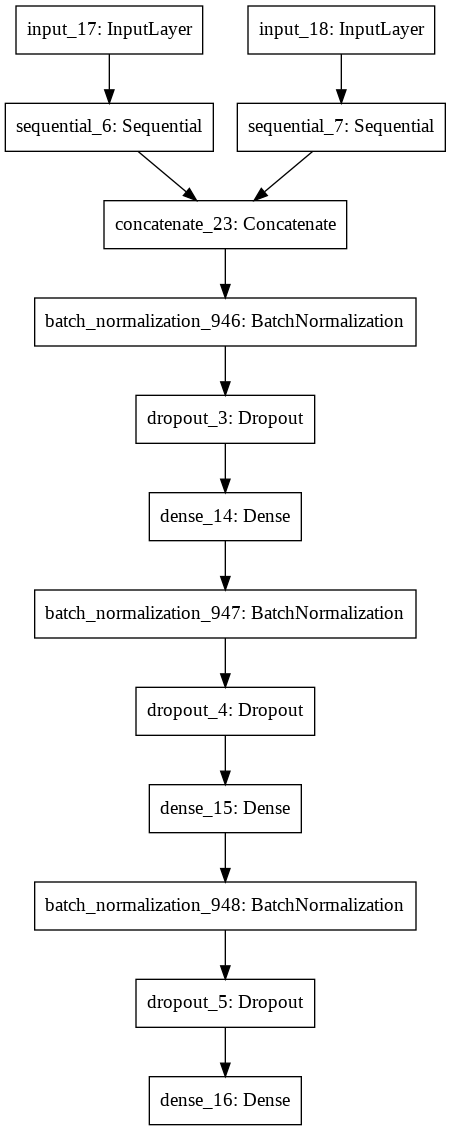

In [ ]:
mdl_9_3_wo_ft_wo_da_BN_DO = create_model_keras_inputs_two_updated(fine_tune = False, add_BN = True, add_Dropout = True)
mdl_9_3_wo_ft_wo_da_BN_DO.summary()
display(plot_model(mdl_9_3_wo_ft_wo_da_BN_DO))

Epoch 1/10
173/173 [==============================] - 37s 168ms/step - loss: 0.4108 - accuracy: 0.8369 - val_loss: 1.0224 - val_accuracy: 0.5672
Epoch 2/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2844 - accuracy: 0.8898 - val_loss: 1.6899 - val_accuracy: 0.5500
Epoch 3/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2325 - accuracy: 0.9117 - val_loss: 0.9456 - val_accuracy: 0.5500
Epoch 4/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2252 - accuracy: 0.9048 - val_loss: 1.3027 - val_accuracy: 0.5707
Epoch 5/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2088 - accuracy: 0.9207 - val_loss: 0.9258 - val_accuracy: 0.5741
Epoch 6/10
173/173 [==============================] - 27s 154ms/step - loss: 0.2191 - accuracy: 0.9208 - val_loss: 1.1707 - val_accuracy: 0.6052
Epoch 7/10
173/173 [==============================] - 27s 154ms/step - loss: 0.1936 - accuracy: 0.9285 - val_loss: 1.4793 - val_ac

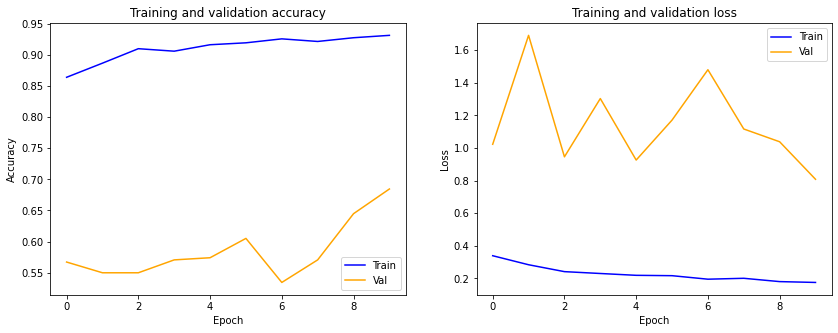

In [ ]:
mdl_9_3_wo_ft_wo_da_BN_DO.compile(optimizer=Adam(learning_rate=0.0005),loss='binary_crossentropy',metrics=['accuracy'])


plot(mdl_9_3_wo_ft_wo_da_BN_DO.fit(X_train,label_train, 
                batch_size=BATCH_SIZE, 
                validation_data =(X_valid, label_valid),  epochs=10))

In [ ]:
#save_weights
mdl_9_3_wo_ft_wo_da_BN_DO.save_weights(os.path.join(saving_dir,"mdl_9_3_wo_ft_wo_da_BN_DO.h5/"))

del mdl_9_3_wo_ft_wo_da_BN_DO